In [1]:
import pandas as pd
import numpy as np
import re
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta

import seaborn as sns
sns.set_style('white')

#### corin's attempts to fit random forest to data

In [2]:
import tensorflow as tf

print(tf.__version__)  # You should see a 2.0.0 here!

import tensorflow.keras as keras

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

2.0.0


Using TensorFlow backend.


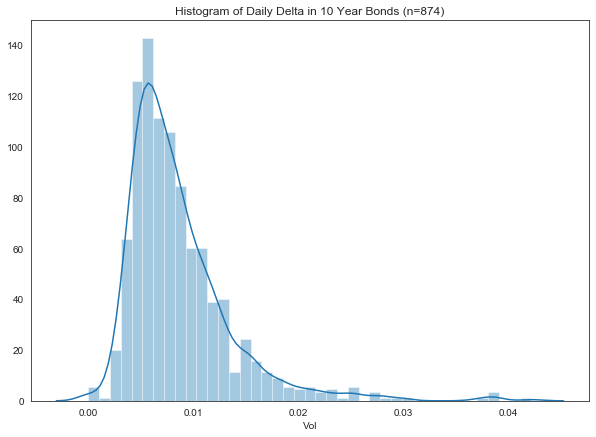

In [3]:
bonds_10 = pd.read_csv('../bonds/adjusted^TNX.csv')
bonds_10['Vol'] = (bonds_10['High'] - bonds_10['Low']) / (bonds_10['High'] + bonds_10['Low'])
#print(bonds_10.head(10))

bonds_30 = pd.read_csv('../bonds/adjusted^TYX.csv')
bonds_30['Vol'] = (bonds_30['High'] - bonds_30['Low']) / (bonds_30['High'] + bonds_30['Low'])
#print(bonds_30.head(10))

fig = plt.figure(figsize=(10,7))
sns.distplot(bonds_10['Vol'])
plt.title(f'Histogram of Daily Delta in 10 Year Bonds (n={len(bonds_10)})')

plt.show()

In [32]:
predictors = pd.read_csv('../tweets/cleaned_tweet_text_by_day')
print(predictors.info())

pred_bonds_10 = pd.merge(left=bonds_10, right=predictors, on='Date') # default is INNER join which is what we want

def add_lookback_predictors(df, num_days=10):
    df.sort_values(by=['Date'])    
    for idx, row in df.iterrows():
        new_val = row['clean_text']
        if idx < num_days:
            df.loc[idx, "new_text"] = new_val
            continue
        for day in range(1,num_days+1):
            new_val += df.loc[idx-day, "clean_text"]
            df.loc[idx, "new_text"] = new_val
    
    return df['new_text'] 
        
num_days = 5
pred_cols2 = add_lookback_predictors(pred_bonds_10, num_days=num_days)
print(pred_cols2[-20:])
pred_bonds_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 8 columns):
Unnamed: 0    1006 non-null float64
Unnamed: 1    1006 non-null float64
Unnamed: 2    1006 non-null float64
clean_text    1005 non-null object
year          1006 non-null float64
month         1006 non-null float64
day           1006 non-null float64
Date          1006 non-null object
dtypes: float64(6), object(2)
memory usage: 63.0+ KB
None
819    This is just the beginning thank you to ByronY...
820    The hardest thing I have to do as President......
821    WOW THANK YOU Minneapolis Minnesota — on my wa...
822    Just landed in Louisiana! Vote against John Be...
823    The U.S. has the worst of the ISIS prisoners. ...
824    The House gone rogue! I want to remind you a l...
825    nanThe StLouisBlues amazing comeback reminds u...
826    Retweet realDonaldTrump: 95% Approval Rating i...
827    See you soon Dallas Texas! Retweet SarahAMatth...
828    REPUBLICANS MUST STICK TOGETHE

In [56]:
vocab_size = 5000
encoded_docs = [one_hot(d, vocab_size) for d in pred_cols2]

# pad documents to a max length of 4 words
max_length = 50*num_days
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

#print(pred_bonds_10[pred_cols2])

X = padded_docs[num_days:568]
Xt = padded_docs[(569+num_days):729]

y = pred_bonds_10['Vol'][num_days:568]
yt = pred_bonds_10['Vol'][(569+num_days):729]

#### adapted from https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [57]:
#kernel_reg = tf.keras.regularizers.l1_l2(l1=0.00001, l2=0.001)
kernel_reg = tf.keras.regularizers.l1_l2(l1=0.00003, l2=0.001)
dropout_c = 0.2

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=(max_length)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=kernel_reg,))
model.add(Dropout(dropout_c))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu', kernel_regularizer=kernel_reg,))
model.add(Dropout(dropout_c))
model.add(Dense(32, activation='relu', kernel_regularizer=kernel_reg,))
#model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))

# compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')

# summarize the model
print(model.summary())

# fit the model
history = model.fit(X, y, epochs=150, batch_size=32, verbose=1, validation_split=0.2)
# evaluate the model

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 250, 8)            40000     
_________________________________________________________________
flatten_10 (Flatten)         (None, 2000)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               256128    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dense_38 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)             

/usr/local/anaconda3/envs/py3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 450 samples, validate on 113 samples
Epoch 1/150
450/450 [==============================] - 2s 5ms/step - loss: 0.9517 - val_loss: 0.6834
Epoch 2/150
450/450 [==============================] - 0s 459us/step - loss: 0.9761 - val_loss: 0.6786
Epoch 3/150
450/450 [==============================] - 0s 446us/step - loss: 0.8665 - val_loss: 0.6681
Epoch 4/150
450/450 [==============================] - 0s 447us/step - loss: 0.8194 - val_loss: 0.6613
Epoch 5/150
450/450 [==============================] - 0s 449us/step - loss: 0.7883 - val_loss: 0.6531
Epoch 6/150
450/450 [==============================] - 0s 472us/step - loss: 0.7674 - val_loss: 0.6448
Epoch 7/150
450/450 [==============================] - 0s 461us/step - loss: 0.7455 - val_loss: 0.6357
Epoch 8/150
450/450 [==============================] - 0s 440us/step - loss: 0.7257 - val_loss: 0.6269
Epoch 9/150
450/450 [==============================] - 0s 454us/step - loss: 0.7044 - val_loss: 0.6165
Epoch 10/150
450/450 [=======

450/450 [==============================] - 0s 518us/step - loss: 0.0506 - val_loss: 0.0500
Epoch 80/150
450/450 [==============================] - 0s 520us/step - loss: 0.0483 - val_loss: 0.0490
Epoch 81/150
450/450 [==============================] - 0s 544us/step - loss: 0.0464 - val_loss: 0.0471
Epoch 82/150
450/450 [==============================] - 0s 502us/step - loss: 0.0445 - val_loss: 0.0442
Epoch 83/150
450/450 [==============================] - 0s 517us/step - loss: 0.0427 - val_loss: 0.0426
Epoch 84/150
450/450 [==============================] - 0s 513us/step - loss: 0.0409 - val_loss: 0.0414
Epoch 85/150
450/450 [==============================] - 0s 518us/step - loss: 0.0392 - val_loss: 0.0397
Epoch 86/150
450/450 [==============================] - 0s 552us/step - loss: 0.0376 - val_loss: 0.0380
Epoch 87/150
450/450 [==============================] - 0s 530us/step - loss: 0.0363 - val_loss: 0.0362
Epoch 88/150
450/450 [==============================] - 0s 507us/step - loss:

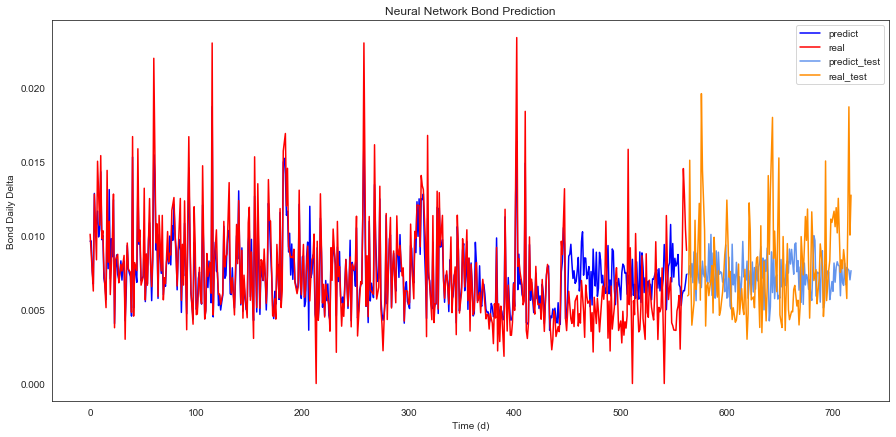

In [58]:
fig = plt.figure(figsize=(15,7))

pred_y = model.predict(X, verbose=0)
pred_yt = model.predict(Xt, verbose=0)

plt.title('Neural Network Bond Prediction')
plt.ylabel('Bond Daily Delta')
plt.xlabel('Time (d)')

plt.plot(range(len(y)), pred_y, c='b', label='predict')
plt.plot(range(len(y)), y, c='r', label='real')
plt.plot(range(len(y),len(yt)+len(y)), pred_yt, c='cornflowerblue', label='predict_test')
plt.plot(range(len(y),len(yt)+len(y)), yt, c='darkorange', label='real_test')

plt.legend(loc='best')
plt.show()

0.005053001909206311
0.006598824808225695
0.006584351131271931
0.0064084095370264774


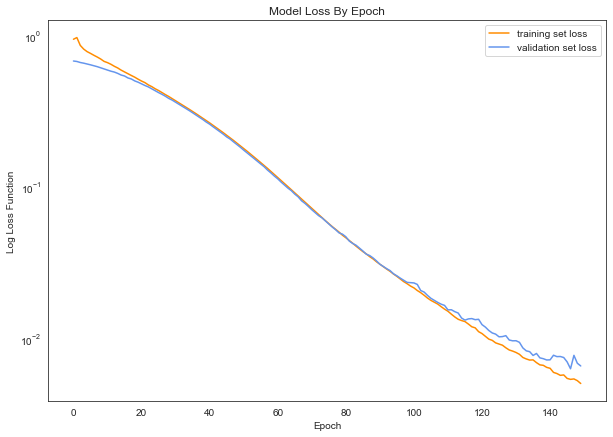

In [60]:
def plot_history(history, ax):
    ax.set_yscale("log", nonposy='clip')
    ax.plot(range(len(history.history['loss'])), history.history['loss'], color='darkorange', label='training set loss')
    ax.plot(range(len(history.history['val_loss'])), history.history['val_loss'], color='cornflowerblue', label='validation set loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log Loss Function')
    ax.set_title('Model Loss By Epoch')
    ax.legend(loc='best')
    
figure = plt.figure(figsize=(10,7))

print(history.history['loss'][-1])
print(history.history['val_loss'][-1])
print(model.evaluate(Xt, yt, verbose=0))

rand_vals = []
for x in range(100):
    rand_yt = np.array(copy.deepcopy(yt))
    np.random.shuffle(rand_yt)
    rand_vals.append(model.evaluate(Xt, rand_yt, verbose=0))
    
print(np.mean(rand_vals))

plot_history(history, figure.gca())
plt.show()